# Elastic Net [vif10]
ElasticNet is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of and using the l1_ratio parameter.

https://scikit-learn.org/stable/modules/linear_model.html#elastic-net

ElasticNet()

{'alpha': 1.0,   
 'copy_X': True,   
 'fit_intercept': True,   
 'l1_ratio': 0.5,   
 'max_iter': 1000,   
 'normalize': 'deprecated',   
 'positive': False,   
 'precompute': False,   
 'random_state': None,   
 'selection': 'cyclic',   
 'tol': 0.0001,   
 'warm_start': False}   
 
**_bayesian hyperparameter tuning_**

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import platform
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize, space
import sys

from validation import cross_validation
from validation import performance_test_shifted

date_format = '%Y-%m-%d'

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

In [2]:
# config 'all', 'vif_5' or 'vif_10'
vif = 'vif_10'

# config model
ml_algorithm = ElasticNet
filename = 'single-model_tau_en'

In [3]:
my_os = platform.system()
print('OS in my system: ',my_os)

if my_os == 'Windows':
    path = str(pathlib.Path().absolute()) + '\\'
    slash = '\\'
else:
    path = str(pathlib.Path().absolute()) + '/'
    slash = '/'

path_3 = path.replace('4_modelling', '3_data_pre-processing')

OS in my system:  Linux


## Load Data

In [4]:
data_set = pd.read_csv(path_3 + 'data_artifacts' + slash + 'data_set_e_spx_3-' + vif + '.csv', index_col=0)

## Original Target Model (no forecast horizon)
### Time Series Cross Validation on Default Model

In [5]:
default_model = ml_algorithm(random_state=23)
default_model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': 23,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [6]:
default_model_scores_ori = cross_validation (data_set, default_model, 'tau_target_ori')
pd.DataFrame(default_model_scores_ori).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000
mean,0.027880,0.029523,0.136403,0.139654,0.0,-0.281342
std,0.001656,0.008054,0.003721,0.028160,0.0,0.327412
min,0.024467,0.022177,0.129251,0.114897,0.0,-1.157235
25%,0.026947,0.023585,0.134445,0.118732,0.0,-0.317034
50%,0.027967,0.026608,0.136745,0.128968,0.0,-0.175782
75%,0.029052,0.031176,0.138914,0.151260,0.0,-0.127222
max,0.029906,0.045619,0.141504,0.191687,0.0,-0.001093


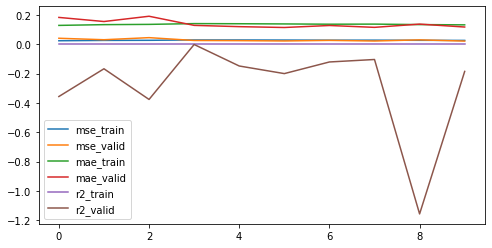

In [7]:
ax = pd.DataFrame(default_model_scores_ori).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [8]:
# search space for the hyperparameters
space = [space.Real(0.0001, 1, name='alpha'), 
         space.Real(0.0001, 1, name='l1_ratio')]

Optimal point: [0.00010233519086875171, 0.20626909572129382]
Function value at optimal point: 0.004681413496722215


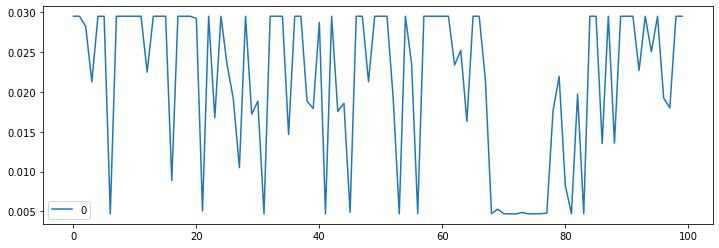

In [9]:
# objective function to minimize
def objective(params):
    alpha, l1_ratio = params
    model = ml_algorithm(alpha=alpha, l1_ratio=l1_ratio, max_iter=7000, random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_ori')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='lbfgs', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [10]:
# ---------------- config opt model -----------------
opt_model_ori = ml_algorithm(alpha=0.00010233519086875171, l1_ratio=0.20626909572129382, max_iter=7000, random_state=23)

In [11]:
opt_model_ori_tscv_scores = cross_validation(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_tscv_scores = pd.DataFrame(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.003763,0.002493,0.048015,0.038165,0.846216,0.918427
1,0.003528,0.003820,0.045950,0.048655,0.868128,0.858176
2,0.003289,0.004685,0.044296,0.055095,0.880201,0.858696
3,0.003433,0.009344,0.045471,0.081907,0.885211,0.644316
4,0.003957,0.007695,0.048855,0.074314,0.867070,0.649069
5,0.004414,0.002975,0.052599,0.042373,0.849006,0.845215
6,0.004372,0.002806,0.052411,0.042460,0.846344,0.883224
7,0.004259,0.002444,0.051558,0.038872,0.850583,0.881267
8,0.003963,0.007414,0.049244,0.070055,0.855813,0.474107
9,0.004375,0.003139,0.052139,0.044603,0.836601,0.832307


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003935,0.004681,0.049054,0.053650,0.858517,0.784480
std,0.000420,0.002531,0.003089,0.016035,0.015947,0.144641
min,0.003289,0.002444,0.044296,0.038165,0.836601,0.474107
25%,0.003587,0.002848,0.046466,0.042394,0.847010,0.694879
50%,0.003960,0.003480,0.049050,0.046629,0.853198,0.851696
75%,0.004343,0.006732,0.051994,0.066315,0.867863,0.875624
max,0.004414,0.009344,0.052599,0.081907,0.885211,0.918427


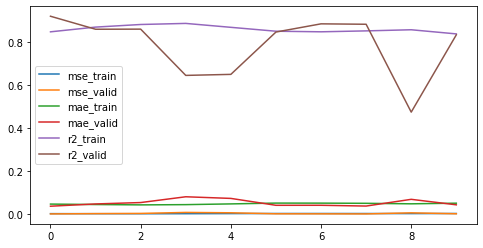

In [12]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

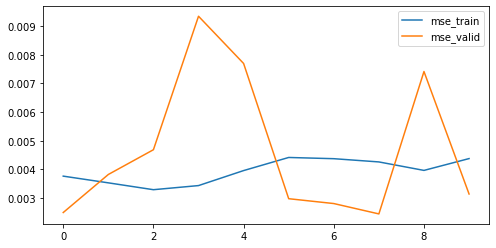

In [13]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

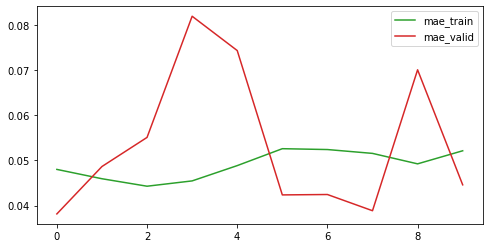

In [14]:
ax = opt_model_ori_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

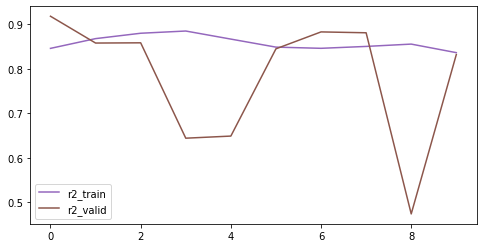

In [15]:
ax = opt_model_ori_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [16]:
opt_model_ori_test_scores = performance_test_shifted(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_test_scores = pd.DataFrame(opt_model_ori_test_scores)
display(opt_model_ori_test_scores)
display(opt_model_ori_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.003566,0.003863,0.046409,0.048994,0.866087,0.856580,0.366445,0.391109
1,0.003541,0.004676,0.046130,0.055063,0.870486,0.858946,0.425448,0.399644
2,0.003456,0.009230,0.045659,0.081329,0.884079,0.648651,0.330819,0.391735
3,0.004073,0.007791,0.049725,0.074924,0.861485,0.644680,0.286654,0.353498
4,0.004317,0.002939,0.051894,0.042091,0.851520,0.847082,0.281294,0.278429
5,0.004228,0.002781,0.051226,0.042275,0.850720,0.884250,0.288558,0.268412
6,0.004149,0.002474,0.050765,0.039081,0.852764,0.879783,0.291026,0.288324
7,0.004010,0.007858,0.049753,0.072526,0.855098,0.442635,0.199579,0.262768
8,0.004307,0.003090,0.051641,0.044119,0.843877,0.834922,0.245124,0.233488
9,0.004211,0.003143,0.050969,0.045389,0.838999,0.848944,0.245513,0.219107


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003986,0.004785,0.049417,0.054579,0.857512,0.774647,0.296046,0.308651
std,0.000335,0.002526,0.002421,0.015721,0.013344,0.146925,0.064764,0.068889
min,0.003456,0.002474,0.045659,0.039081,0.838999,0.442635,0.199579,0.219107
25%,0.003677,0.002977,0.047238,0.042736,0.850920,0.695219,0.254458,0.264179
50%,0.004111,0.003503,0.050259,0.047191,0.853931,0.848013,0.287606,0.283377
75%,0.004224,0.007013,0.051162,0.068160,0.864936,0.858354,0.320871,0.381706
max,0.004317,0.009230,0.051894,0.081329,0.884079,0.884250,0.425448,0.399644


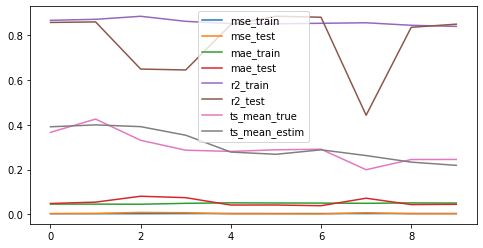

In [17]:
ax = opt_model_ori_test_scores.plot(figsize=(8,4))

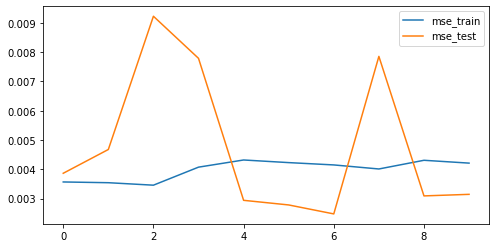

In [18]:
ax = opt_model_ori_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

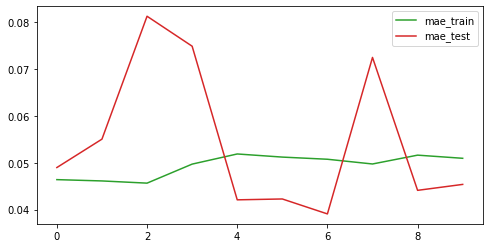

In [19]:
ax = opt_model_ori_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

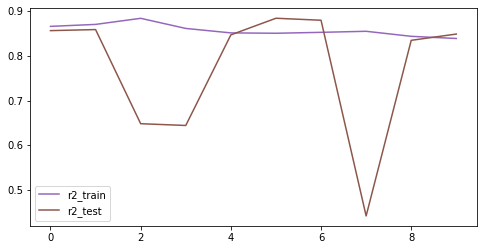

In [20]:
ax = opt_model_ori_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

In [21]:
opt_model_ori_test_scores

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.003566,0.003863,0.046409,0.048994,0.866087,0.856580,0.366445,0.391109
1,0.003541,0.004676,0.046130,0.055063,0.870486,0.858946,0.425448,0.399644
2,0.003456,0.009230,0.045659,0.081329,0.884079,0.648651,0.330819,0.391735
3,0.004073,0.007791,0.049725,0.074924,0.861485,0.644680,0.286654,0.353498
4,0.004317,0.002939,0.051894,0.042091,0.851520,0.847082,0.281294,0.278429
5,0.004228,0.002781,0.051226,0.042275,0.850720,0.884250,0.288558,0.268412
6,0.004149,0.002474,0.050765,0.039081,0.852764,0.879783,0.291026,0.288324
7,0.004010,0.007858,0.049753,0.072526,0.855098,0.442635,0.199579,0.262768
8,0.004307,0.003090,0.051641,0.044119,0.843877,0.834922,0.245124,0.233488
9,0.004211,0.003143,0.050969,0.045389,0.838999,0.848944,0.245513,0.219107


(0.2, 0.45)

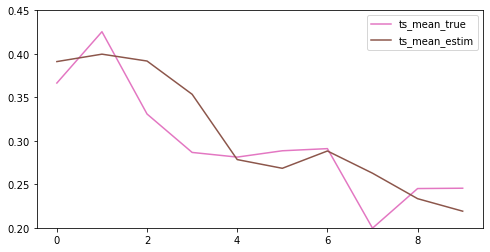

In [22]:
ax = opt_model_ori_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [23]:
results_ori = {'Model': [opt_model_ori],
            'fc_horizon': 0,
            'vif': [vif],
            'mse_tscv_t': [opt_model_ori_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_ori_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_ori_test_scores.mse_train.mean()],
            'mse_test': [opt_model_ori_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_ori_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_ori_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_ori_test_scores.mae_train.mean()],
            'mae_test': [opt_model_ori_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_ori_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_ori_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_ori_test_scores.r2_train.mean()],
            'r2_test': [opt_model_ori_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_ori.get_params()],
            'ts_mean_true': opt_model_ori_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_ori_test_scores.ts_mean_estim.mean(),
              }

## ----------------------------------------------------------
## Predicted Target Model (one year forecast horizon)
### Time Series Cross Validation on Default Model

In [24]:
default_model_scores_hor = cross_validation (data_set, default_model, 'tau_target_hor')
pd.DataFrame(default_model_scores_hor).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000
mean,0.027540,0.027336,0.134596,0.132017,0.0,-0.253414
std,0.001493,0.007255,0.003881,0.024994,0.0,0.331503
min,0.025133,0.022326,0.127670,0.112634,0.0,-1.156883
25%,0.026501,0.022588,0.131786,0.117745,0.0,-0.194664
50%,0.027556,0.025065,0.134846,0.122276,0.0,-0.144827
75%,0.028700,0.028926,0.137419,0.134389,0.0,-0.113195
max,0.029472,0.045869,0.139845,0.192933,0.0,-0.000813


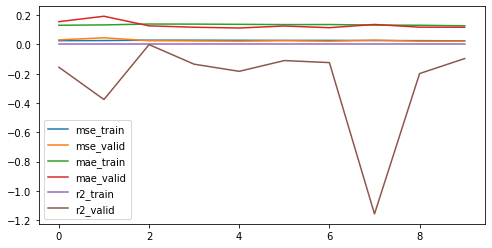

In [25]:
ax = pd.DataFrame(default_model_scores_hor).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

Optimal point: [0.0008636922946648973, 0.906938878208958]
Function value at optimal point: 0.009150325981307755


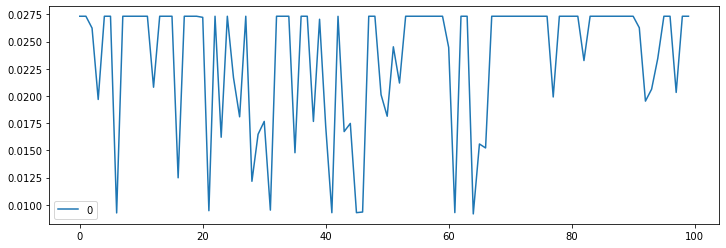

In [26]:
# objective function to minimize
def objective(params):
    alpha, l1_ratio = params
    model = ml_algorithm(alpha=alpha, l1_ratio=l1_ratio, max_iter=7000, random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_hor')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='lbfgs', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [27]:
# ---------------- config opt model -----------------
opt_model_hor = ml_algorithm(alpha=0.0008636922946648973, l1_ratio=0.906938878208958, max_iter=7000, random_state=23)

In [28]:
opt_model_hor_tscv_scores = cross_validation(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_tscv_scores = pd.DataFrame(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.008108,0.006090,0.072915,0.059095,0.688092,0.776229
1,0.007570,0.010061,0.069663,0.081466,0.718072,0.698243
2,0.007834,0.015616,0.070491,0.104680,0.734193,0.391716
3,0.008957,0.013383,0.076101,0.099664,0.695366,0.378693
4,0.009566,0.010084,0.079562,0.083242,0.668721,0.471624
5,0.009795,0.005853,0.080652,0.060635,0.652269,0.752213
6,0.009422,0.005493,0.078474,0.058117,0.665220,0.723968
7,0.008395,0.013505,0.073130,0.096853,0.688735,0.023520
8,0.008260,0.005872,0.072191,0.061592,0.686932,0.684774
9,0.007879,0.005546,0.069833,0.059275,0.686512,0.731168


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.008579,0.009150,0.074301,0.076462,0.688411,0.563215
std,0.000798,0.003912,0.004115,0.018934,0.024180,0.242962
min,0.007570,0.005493,0.069663,0.058117,0.652269,0.023520
25%,0.007936,0.005858,0.070916,0.059615,0.673169,0.411693
50%,0.008327,0.008076,0.073023,0.071529,0.687512,0.691508
75%,0.009306,0.012558,0.077881,0.093450,0.693708,0.729368
max,0.009795,0.015616,0.080652,0.104680,0.734193,0.776229


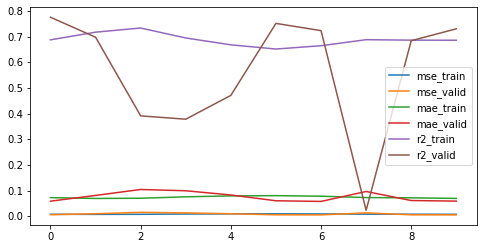

In [29]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

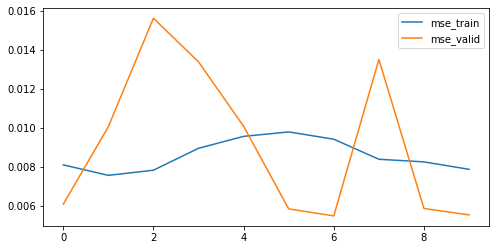

In [30]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

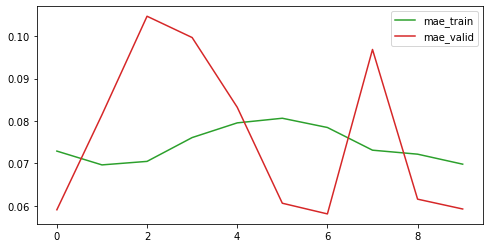

In [31]:
ax = opt_model_hor_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

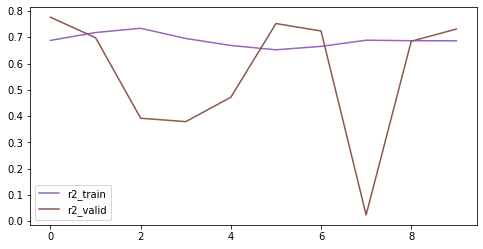

In [32]:
ax = opt_model_hor_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [33]:
opt_model_hor_test_scores = performance_test_shifted(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_test_scores = pd.DataFrame(opt_model_hor_test_scores)
display(opt_model_hor_test_scores)
display(opt_model_hor_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.007846,0.010245,0.071157,0.082551,0.705848,0.692732,0.429797,0.387261
1,0.007789,0.015493,0.070447,0.104244,0.734616,0.396501,0.335499,0.416097
2,0.008759,0.013062,0.075309,0.098260,0.697199,0.393582,0.293080,0.384873
3,0.009406,0.009803,0.078811,0.081712,0.671735,0.486347,0.287144,0.355634
4,0.009564,0.005750,0.079539,0.060232,0.657860,0.756601,0.295090,0.311275
5,0.009221,0.005567,0.077651,0.058422,0.668948,0.720258,0.292463,0.300056
6,0.008849,0.015176,0.075494,0.103423,0.675623,-0.097310,0.205042,0.303171
7,0.008841,0.006127,0.075110,0.062811,0.673322,0.671080,0.247086,0.260243
8,0.007942,0.005467,0.070728,0.058456,0.692104,0.734984,0.248710,0.241779
9,0.007568,0.018938,0.068458,0.120919,0.694709,-0.015222,0.342639,0.229655


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.008579,0.010563,0.074270,0.083103,0.687196,0.473955,0.297655,0.319005
std,0.000733,0.004904,0.003855,0.022787,0.022451,0.311566,0.062015,0.064838
min,0.007568,0.005467,0.068458,0.058422,0.657860,-0.097310,0.205042,0.229655
25%,0.007870,0.005844,0.070836,0.060877,0.672131,0.394311,0.258318,0.270197
50%,0.008800,0.010024,0.075210,0.082132,0.683864,0.578714,0.292772,0.307223
75%,0.009128,0.014648,0.077112,0.102132,0.696576,0.713376,0.325397,0.377563
max,0.009564,0.018938,0.079539,0.120919,0.734616,0.756601,0.429797,0.416097


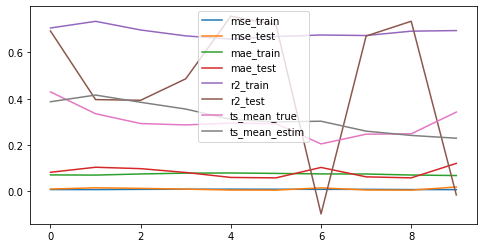

In [34]:
ax = opt_model_hor_test_scores.plot(figsize=(8,4))

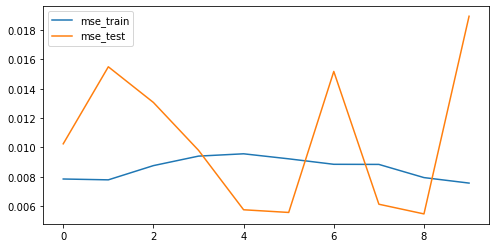

In [35]:
ax = opt_model_hor_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

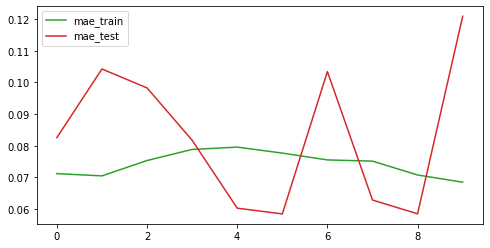

In [36]:
ax = opt_model_hor_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

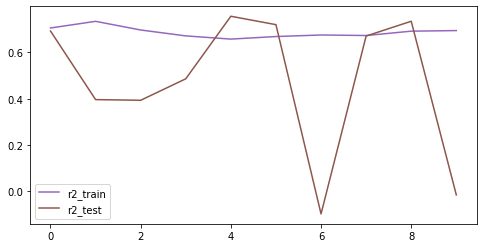

In [37]:
ax = opt_model_hor_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

(0.2, 0.45)

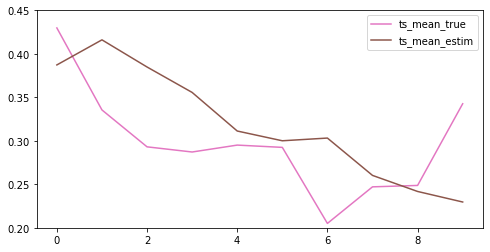

In [38]:
ax = opt_model_hor_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [39]:
results_hor = {'Model': [opt_model_ori],
            'fc_horizon': 1,
            'vif': [vif],
            'mse_tscv_t': [opt_model_hor_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_hor_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_hor_test_scores.mse_train.mean()],
            'mse_test': [opt_model_hor_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_hor_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_hor_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_hor_test_scores.mae_train.mean()],
            'mae_test': [opt_model_hor_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_hor_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_hor_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_hor_test_scores.r2_train.mean()],
            'r2_test': [opt_model_hor_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_hor.get_params()],
            'ts_mean_true': opt_model_hor_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_hor_test_scores.ts_mean_estim.mean(),
              }

## Safe to Excel

In [40]:
results = pd.concat([pd.DataFrame(results_ori), pd.DataFrame(results_hor)])

display(results)

storage_name = filename + '_' + vif + '_' + str(datetime.today().day) + '.xlsx'

pd.DataFrame(results).to_excel(path + 'artifacts' + slash + storage_name, index=None)

,Model,fc_horizon,vif,mse_tscv_t,mse_tscv_v,mse_train,mse_test,mae_tscv_t,mae_tscv_v,mae_train,mae_test,r2_tscv_t,r2_tscv_v,r2_train,r2_test,opt_model,ts_mean_true,ts_mean_estim
0,"ElasticNet(alpha=0.00010233519086875171, l1_ratio=0.20626909572129382,\n max_iter=7000, random_state=23)",0,vif_10,0.003935,0.004681,0.003986,0.004785,0.049054,0.053650,0.049417,0.054579,0.858517,0.784480,0.857512,0.774647,"{'alpha': 0.00010233519086875171, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.20626909572129382, 'max_iter': 7000, 'positive': False, 'precompute': False, 'random_state': 23, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}",0.296046,0.308651
0,"ElasticNet(alpha=0.00010233519086875171, l1_ratio=0.20626909572129382,\n max_iter=7000, random_state=23)",1,vif_10,0.008579,0.009150,0.008579,0.010563,0.074301,0.076462,0.074270,0.083103,0.688411,0.563215,0.687196,0.473955,"{'alpha': 0.0008636922946648973, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.906938878208958, 'max_iter': 7000, 'positive': False, 'precompute': False, 'random_state': 23, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}",0.297655,0.319005
